In [1]:
import pandas as pd
import numpy as np
import random
from xgboost import XGBClassifier
from sklearn.dummy import DummyClassifier
from sklearn.calibration import CalibrationDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
#Fake data
fd = {
    'game_seconds': [random.randrange(0, 50) for i in range(1000)],
    'game_period': [random.randrange(0, 5) for i in range(1000)],
    'x': [random.randrange(0, 50) for i in range(1000)],
    'y': [random.randrange(0, 25) for i in range(1000)],
    'distance': [random.randrange(0, 50) for i in range(1000)],
    'angle': [random.randrange(0, 90) for i in range(1000)],
    'type': [random.choice(['A', 'B', 'C', 'D']) for i in range(1000)],
    'is_goal': [random.randrange(0, 2) for i in range(1000)],
    'empty_net': [random.randrange(0, 2) for i in range(1000)],
    
    'last_event_type': [random.choice(['e1', 'e2', 'e3', 'e4']) for i in range(1000)],
    'last_x': [random.randrange(0, 50) for i in range(1000)],
    'last_y': [random.randrange(0, 25) for i in range(1000)],
    'last_time': [random.randrange(0, 60) for i in range(1000)],
    'last_distance': [random.randrange(0, 60) for i in range(1000)],
    
}

In [3]:
df = pd.DataFrame(fd)
df.head()

,game_seconds,game_period,x,y,distance,angle,type,is_goal,empty_net,last_event_type,last_x,last_y,last_time,last_distance
0,14,0,0,23,41,38,A,1,1,e4,1,15,43,50
1,34,2,14,13,17,19,C,1,0,e3,34,11,22,12
2,18,0,39,20,38,43,A,0,1,e3,10,6,21,47
3,39,3,1,10,41,62,D,0,0,e2,44,15,13,8
4,24,2,11,3,10,76,C,1,1,e4,20,20,31,7


In [4]:
X = df.drop('is_goal', 1)
y = df['is_goal'].to_numpy()
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=73)

### Question-1:

In [5]:
### XGBoost on distance+angle ###

X_train1 = X_train[['distance', 'angle']].to_numpy().reshape(-1, 2)
X_val1 = X_val[['distance', 'angle']].to_numpy().reshape(-1, 2)

xgb_clf1 = XGBClassifier().fit(X_train1, y_train)

train_score1 = xgb_clf1.score(X_train1, y_train)
val_score1 = xgb_clf1.score(X_val1, y_val)

print(f'Training accuracy: {train_score1}')
print(f'Validation accuracy: {val_score1}')

[04:37:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training accuracy: 0.89625
Validation accuracy: 0.485


In [6]:
### Random baseline ###
random_clf = DummyClassifier(strategy="uniform").fit(X_train1, y_train)

train_score0 = random_clf.score(X_train1, y_train)
val_score0 = random_clf.score(X_val1, y_val)

print(f'Training accuracy: {train_score0}')
print(f'Validation accuracy: {val_score0}')

Training accuracy: 0.46625
Validation accuracy: 0.485


XGBoost (trained on distance+angle): ROC AUC=0.504
Random: ROC AUC=0.500


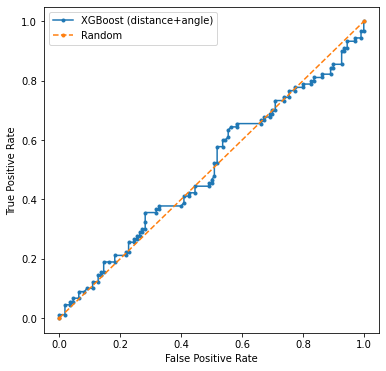

In [7]:
### ROC curve - AUC metric ###

xgb_probs1 = xgb_clf1.predict_proba(X_val1[:, :])[:,1]
random_probs = random_clf.predict_proba(X_val1[:, :])[:,1]


xgb_auc1 = roc_auc_score(y_val, xgb_probs1)
random_auc = roc_auc_score(y_val, random_probs)

print('XGBoost (trained on distance+angle): ROC AUC=%.3f' % (xgb_auc1))
print('Random: ROC AUC=%.3f' % (random_auc))

xgb_fpr1, xgb_tpr1, _ = roc_curve(y_val, xgb_probs1)
random_fpr, random_tpr, _ = roc_curve(y_val, random_probs)

plt.figure(figsize=(6, 6))

plt.plot(xgb_fpr1, xgb_tpr1, marker='.', label='XGBoost (distance+angle)')
plt.plot(random_fpr, random_tpr, linestyle='--', marker='.', label='Random')


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

# plt.savefig('../figures/roc.png')

plt.show()

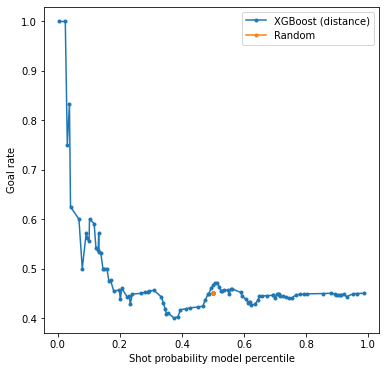

In [8]:
### goal_rate = F(shot probability model percentile) ###
def compute_goal_rate_per_percentile(probs, y):
    percentiles = []
    rates = []

    for i in range(0, 101):
        percentile = np.percentile(probs, i)
        goals = 0
        no_goals = 0
        for idx, p in enumerate(probs):
            if p<=percentile:
                if y[idx]==1:
                    goals+=1
                else:
                    no_goals+=1
        rate = goals / (goals + no_goals)
        percentiles.append(percentile)
        rates.append(rate)
    return percentiles, rates


percentiles1, rates1 = compute_goal_rate_per_percentile(xgb_probs1, y_val)
percentiles2, rates2 = compute_goal_rate_per_percentile(random_probs, y_val)

plt.figure(figsize=(6, 6))

plt.plot(percentiles1, rates1, marker='.', label='XGBoost (distance)')
plt.plot(percentiles2, rates2, marker='.', label='Random')

plt.xlabel('Shot probability model percentile')
plt.ylabel('Goal rate')
plt.legend()

# plt.savefig('../figures/goal_rate_percentile_1.png')

plt.show()

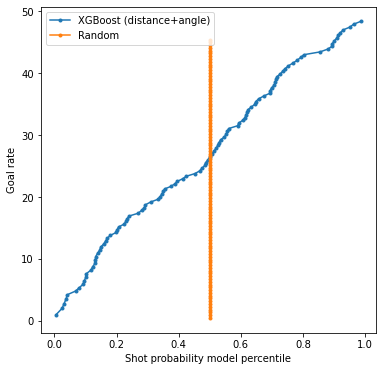

In [9]:
### cumulative portion of goals = F(shot probability model percentile) ###

def compute_cumulative_goal_rate_per_percentile(probs, y):
    percentiles = []
    rates = []
    cum_rate = 0

    for i in range(0, 101):
        percentile = np.percentile(probs, i)
        goals = 0
        no_goals = 0
        for idx, p in enumerate(probs):
            if p<=percentile:
                if y[idx]==1:
                    goals+=1
                else:
                    no_goals+=1
        cum_rate += goals / (goals + no_goals)
        percentiles.append(percentile)
        rates.append(cum_rate)
    return percentiles, rates


percentiles1, rates1 = compute_cumulative_goal_rate_per_percentile(xgb_probs1, y_val)
percentiles2, rates2 = compute_cumulative_goal_rate_per_percentile(random_probs, y_val)

plt.figure(figsize=(6, 6))

plt.plot(percentiles1, rates1, marker='.', label='XGBoost (distance+angle)')
plt.plot(percentiles2, rates2, marker='.', label='Random')

plt.xlabel('Shot probability model percentile')
plt.ylabel('Goal rate')
plt.legend()

# plt.savefig('../figures/goal_rate_percentile_2.png')

plt.show()

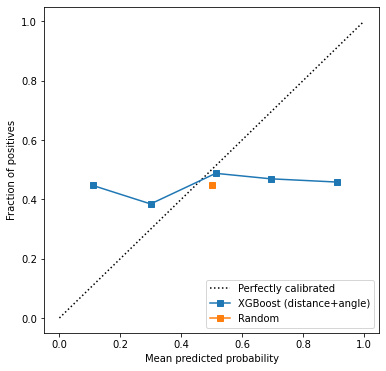

In [11]:
fig, ax = plt.subplots(figsize=(6, 6))

disp1 = CalibrationDisplay.from_estimator(xgb_clf1, X_val1, y_val, label='XGBoost (distance+angle)', ax=ax)
disp4 = CalibrationDisplay.from_estimator(random_clf, X_val1, y_val, label='Random', ax=ax)

# plt.savefig('../figures/calibration_diagram.png')

plt.show()